# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [7]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [8]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [9]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [10]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
   
        
    # 1: Implement function and return a dataloader
   
    transform = transforms.Compose([transforms.Resize(image_size),
                                          transforms.ToTensor()])

    # 2: Load the dataset with ImageFolder


    train_data = datasets.ImageFolder(data_dir, transform = transform)



    # 3: Using the image datasets and the trainforms, define the dataloader

    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    
    return trainloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [11]:
# Define function hyperparameters
batch_size = 32 # updated batch size from 128 to 32 per review
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

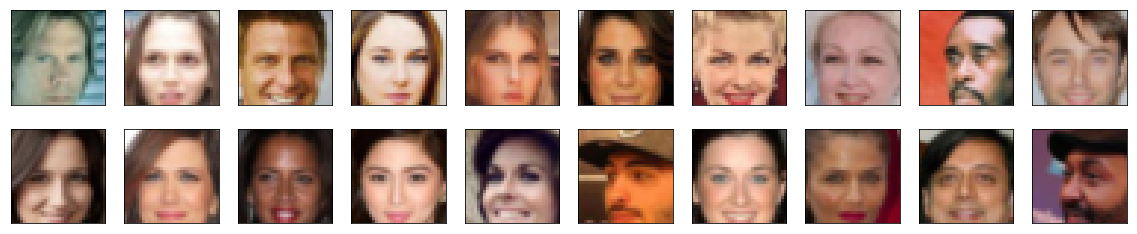

In [12]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [13]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min, max = feature_range
    x = x * (max - min) + min
    
    return x


In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8980)
Max:  tensor(0.6863)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
# Defining a conv function as taught by the lessons

def conv(in_channels, out_channels, kernel_size = 4, stride = 2, 
        padding = 1, batch_norm = True):
    
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                          kernel_size, stride, padding, bias = False)
    
    # append the conv layer
    layers.append(conv_layer)
    
    if batch_norm:
        # append the batch_norm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


In [17]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        #32 x 32 input layer with no batch_norm
        self.conv1 = conv(3, conv_dim, batch_norm = False)
        # 16x16 layer
        self.conv2 = conv(conv_dim, conv_dim*2)
        
        #8x8 layer
        self.conv3 = conv(conv_dim*2, conv_dim*4)
        
        # final fully connected layer
        # 4 x 4 output with conv_dim*4 depth
        # no batch_norm
        self.fc1 = nn.Linear(conv_dim*4*4*4, 1000)
        
        # adding an additional layers per review comments
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 1)
        
        # dropout
        self.dropout = nn.Dropout(0.3)
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        #0.2 is the slope for the leaky_relu function
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out),0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten the output to feed the fc layer
        # the last layer is a 4x4 input with conv_dim*4 depth
        out = out.view(-1, self.conv_dim*4*4*4)
        
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [18]:
# using a helper deconv function

def deconv(in_channels, out_channels, kernel_size=4, stride=2, 
          padding=1, batch_norm = True):
    
    # create a sequence of transpose + optional batch norm layers
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels,
                                     kernel_size, stride, padding, bias = False)
    
    
    # append the conv layer
    layers.append(deconv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)
        

In [19]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        #Reverse from the Discriminator
        # input is z_size, output is the 4x4 matrix + conv_dim*4 depth        
        #conv_dim*4 will be the input to the transpose convolutional layer
        # no batch_norm
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        #4x4 input to 8#8 output
        self.deconv1 = deconv(conv_dim*4, conv_dim*2)
        
        # 16x 16 output
        self.deconv2 = deconv(conv_dim*2, conv_dim)
        
        # 32x 32 output
        # no batch norm on the last layer
        self.deconv3 = deconv(conv_dim, 3, batch_norm = False)   
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        out = self.fc(x)
        # transform the output for convolutional layer
        out = out.view (-1, self.conv_dim*4,4,4)
        
        # convolutional layers
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
                
        out = F.tanh(self.deconv3(out))
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [20]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    # TODO: Apply initial weights to convolutional and linear layers
    # for every linear later in a model
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0, 0.02) 
        m.bias.data.fill_(0) 
    elif classname.find('Conv') != -1:
        m.weight.data.normal_(0, 0.02)
        #m.bias.data.fill_(0)
        
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [22]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=2048, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [24]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    smooth = True
    if smooth:
        # real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
        
    if train_on_gpu:
        labels = labels.cuda()

    # use binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()

    # calculate the loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    ''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [25]:
import torch.optim as optim

# updated hyperparameters
lr= 0.0002 
beta1 = 0.2 #updated the beta1 from 0.5 to 0.2 per review
beta2 =0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [26]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # zero out the gradient
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            
            # Compute the discriminator losses based off of real images
            # check if using GPU and move images
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # Train with real images
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Train with fake images
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            # move to GPU if available
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            
            # Compute the discriminator losses based on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # combine the real and fake losses
            # perform backprop and step through optimizer
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            
            g_optimizer.zero_grad()
        
       
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop and step through optimizer
            g_loss.backward()
            g_optimizer.step()
            
    
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [27]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.3739 | g_loss: 0.8485
Epoch [    1/   50] | d_loss: 0.5796 | g_loss: 4.2226
Epoch [    1/   50] | d_loss: 0.5378 | g_loss: 1.9076
Epoch [    1/   50] | d_loss: 0.5365 | g_loss: 2.6664
Epoch [    1/   50] | d_loss: 0.5591 | g_loss: 2.3422
Epoch [    1/   50] | d_loss: 0.5174 | g_loss: 2.7818
Epoch [    1/   50] | d_loss: 0.6659 | g_loss: 2.6636
Epoch [    1/   50] | d_loss: 1.2110 | g_loss: 0.8198
Epoch [    1/   50] | d_loss: 0.6031 | g_loss: 1.8356
Epoch [    1/   50] | d_loss: 0.6405 | g_loss: 1.8470
Epoch [    1/   50] | d_loss: 0.7594 | g_loss: 1.3725
Epoch [    1/   50] | d_loss: 0.9931 | g_loss: 2.6419
Epoch [    1/   50] | d_loss: 1.8478 | g_loss: 0.5479
Epoch [    1/   50] | d_loss: 0.8683 | g_loss: 1.3703
Epoch [    1/   50] | d_loss: 1.0393 | g_loss: 1.3894
Epoch [    1/   50] | d_loss: 1.0877 | g_loss: 1.5088
Epoch [    1/   50] | d_loss: 1.2444 | g_loss: 0.8819
Epoch [    1/   50] | d_loss: 1.3289 | g_loss: 0.6500
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 1.0219 | g_loss: 0.6523
Epoch [    3/   50] | d_loss: 1.0474 | g_loss: 0.9455
Epoch [    3/   50] | d_loss: 1.0114 | g_loss: 1.2002
Epoch [    3/   50] | d_loss: 0.6877 | g_loss: 1.9255
Epoch [    3/   50] | d_loss: 1.0538 | g_loss: 1.2281
Epoch [    3/   50] | d_loss: 0.8379 | g_loss: 1.6013
Epoch [    3/   50] | d_loss: 1.4025 | g_loss: 1.6105
Epoch [    3/   50] | d_loss: 1.0218 | g_loss: 1.3788
Epoch [    3/   50] | d_loss: 1.0110 | g_loss: 2.2359
Epoch [    3/   50] | d_loss: 1.0839 | g_loss: 1.5817
Epoch [    3/   50] | d_loss: 1.2670 | g_loss: 0.7261
Epoch [    3/   50] | d_loss: 0.9927 | g_loss: 1.3778
Epoch [    3/   50] | d_loss: 1.6104 | g_loss: 2.6034
Epoch [    3/   50] | d_loss: 1.0565 | g_loss: 1.4874
Epoch [    3/   50] | d_loss: 1.0104 | g_loss: 0.9796
Epoch [    3/   50] | d_loss: 1.2038 | g_loss: 1.3086
Epoch [    3/   50] | d_loss: 1.1738 | g_loss: 1.0194
Epoch [    3/   50] | d_loss: 0.9580 | g_loss: 1.2227
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 1.1239 | g_loss: 1.3602
Epoch [    6/   50] | d_loss: 0.9056 | g_loss: 1.7739
Epoch [    6/   50] | d_loss: 1.2957 | g_loss: 0.7849
Epoch [    6/   50] | d_loss: 1.0996 | g_loss: 1.1733
Epoch [    6/   50] | d_loss: 1.3242 | g_loss: 2.6118
Epoch [    6/   50] | d_loss: 1.0175 | g_loss: 1.5902
Epoch [    6/   50] | d_loss: 0.9724 | g_loss: 1.3800
Epoch [    6/   50] | d_loss: 0.9231 | g_loss: 1.4775
Epoch [    6/   50] | d_loss: 1.0654 | g_loss: 1.4974
Epoch [    6/   50] | d_loss: 1.3570 | g_loss: 1.5277
Epoch [    6/   50] | d_loss: 1.0598 | g_loss: 1.0046
Epoch [    6/   50] | d_loss: 1.4288 | g_loss: 1.0996
Epoch [    6/   50] | d_loss: 0.9235 | g_loss: 1.5936
Epoch [    6/   50] | d_loss: 0.8531 | g_loss: 1.4995
Epoch [    6/   50] | d_loss: 0.8731 | g_loss: 1.2788
Epoch [    6/   50] | d_loss: 0.7673 | g_loss: 1.3688
Epoch [    6/   50] | d_loss: 0.7845 | g_loss: 1.3130
Epoch [    6/   50] | d_loss: 1.4544 | g_loss: 0.5635
Epoch [    6/   50] | d_loss

Epoch [    9/   50] | d_loss: 0.7766 | g_loss: 2.2614
Epoch [    9/   50] | d_loss: 0.8241 | g_loss: 1.8690
Epoch [    9/   50] | d_loss: 0.8925 | g_loss: 1.2781
Epoch [    9/   50] | d_loss: 0.7834 | g_loss: 1.8261
Epoch [    9/   50] | d_loss: 0.9737 | g_loss: 1.3949
Epoch [    9/   50] | d_loss: 0.7805 | g_loss: 1.9991
Epoch [    9/   50] | d_loss: 1.3001 | g_loss: 2.7232
Epoch [    9/   50] | d_loss: 0.9141 | g_loss: 1.6291
Epoch [    9/   50] | d_loss: 0.7519 | g_loss: 2.1658
Epoch [    9/   50] | d_loss: 0.9847 | g_loss: 1.3764
Epoch [    9/   50] | d_loss: 0.7952 | g_loss: 2.3366
Epoch [    9/   50] | d_loss: 1.3836 | g_loss: 2.5537
Epoch [    9/   50] | d_loss: 0.8347 | g_loss: 2.0030
Epoch [    9/   50] | d_loss: 1.0257 | g_loss: 2.8760
Epoch [    9/   50] | d_loss: 0.9798 | g_loss: 1.1810
Epoch [    9/   50] | d_loss: 0.8078 | g_loss: 1.9295
Epoch [    9/   50] | d_loss: 0.7417 | g_loss: 1.9019
Epoch [    9/   50] | d_loss: 0.7217 | g_loss: 2.3188
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.8589 | g_loss: 2.0504
Epoch [   11/   50] | d_loss: 0.9150 | g_loss: 2.1820
Epoch [   11/   50] | d_loss: 0.9830 | g_loss: 1.1752
Epoch [   11/   50] | d_loss: 0.6981 | g_loss: 3.9715
Epoch [   11/   50] | d_loss: 0.7889 | g_loss: 2.1694
Epoch [   11/   50] | d_loss: 0.5863 | g_loss: 2.0826
Epoch [   11/   50] | d_loss: 0.9116 | g_loss: 2.0862
Epoch [   11/   50] | d_loss: 0.7707 | g_loss: 1.8987
Epoch [   11/   50] | d_loss: 0.5484 | g_loss: 2.3820
Epoch [   11/   50] | d_loss: 0.9022 | g_loss: 2.4163
Epoch [   11/   50] | d_loss: 0.7047 | g_loss: 2.1511
Epoch [   11/   50] | d_loss: 0.6970 | g_loss: 1.8441
Epoch [   11/   50] | d_loss: 0.7643 | g_loss: 2.1269
Epoch [   11/   50] | d_loss: 0.8484 | g_loss: 2.4994
Epoch [   11/   50] | d_loss: 0.8721 | g_loss: 2.2864
Epoch [   11/   50] | d_loss: 0.7499 | g_loss: 2.0019
Epoch [   11/   50] | d_loss: 0.8627 | g_loss: 1.6538
Epoch [   11/   50] | d_loss: 0.8733 | g_loss: 1.1475
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 1.1288 | g_loss: 1.1287
Epoch [   14/   50] | d_loss: 0.9382 | g_loss: 1.6386
Epoch [   14/   50] | d_loss: 0.4832 | g_loss: 2.3441
Epoch [   14/   50] | d_loss: 0.6933 | g_loss: 3.2767
Epoch [   14/   50] | d_loss: 0.7508 | g_loss: 1.2482
Epoch [   14/   50] | d_loss: 0.6501 | g_loss: 3.1772
Epoch [   14/   50] | d_loss: 0.8860 | g_loss: 1.6871
Epoch [   14/   50] | d_loss: 0.9206 | g_loss: 1.4154
Epoch [   14/   50] | d_loss: 0.9050 | g_loss: 1.8084
Epoch [   14/   50] | d_loss: 0.5643 | g_loss: 2.0707
Epoch [   14/   50] | d_loss: 0.9648 | g_loss: 1.1940
Epoch [   14/   50] | d_loss: 0.6804 | g_loss: 2.7650
Epoch [   14/   50] | d_loss: 2.1181 | g_loss: 4.4275
Epoch [   14/   50] | d_loss: 0.7625 | g_loss: 1.7832
Epoch [   14/   50] | d_loss: 0.8261 | g_loss: 1.8000
Epoch [   14/   50] | d_loss: 0.5445 | g_loss: 3.3009
Epoch [   14/   50] | d_loss: 0.6509 | g_loss: 2.0037
Epoch [   14/   50] | d_loss: 0.8348 | g_loss: 2.3058
Epoch [   14/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.9624 | g_loss: 1.6305
Epoch [   17/   50] | d_loss: 0.5867 | g_loss: 2.3957
Epoch [   17/   50] | d_loss: 0.8885 | g_loss: 2.4729
Epoch [   17/   50] | d_loss: 1.0094 | g_loss: 0.9841
Epoch [   17/   50] | d_loss: 0.7170 | g_loss: 2.1008
Epoch [   17/   50] | d_loss: 0.6584 | g_loss: 2.3918
Epoch [   17/   50] | d_loss: 0.6934 | g_loss: 1.4982
Epoch [   17/   50] | d_loss: 0.4987 | g_loss: 3.5280
Epoch [   17/   50] | d_loss: 0.8971 | g_loss: 1.0999
Epoch [   17/   50] | d_loss: 0.8043 | g_loss: 1.5195
Epoch [   17/   50] | d_loss: 0.5755 | g_loss: 3.2076
Epoch [   17/   50] | d_loss: 0.5801 | g_loss: 3.2810
Epoch [   17/   50] | d_loss: 0.5631 | g_loss: 2.2300
Epoch [   17/   50] | d_loss: 1.0604 | g_loss: 1.2940
Epoch [   17/   50] | d_loss: 0.6829 | g_loss: 1.6739
Epoch [   17/   50] | d_loss: 0.6892 | g_loss: 2.7027
Epoch [   17/   50] | d_loss: 0.8186 | g_loss: 3.0666
Epoch [   17/   50] | d_loss: 0.8182 | g_loss: 1.8158
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.6067 | g_loss: 3.2805
Epoch [   19/   50] | d_loss: 0.8491 | g_loss: 1.7942
Epoch [   19/   50] | d_loss: 0.7346 | g_loss: 2.5798
Epoch [   19/   50] | d_loss: 0.9414 | g_loss: 1.0567
Epoch [   19/   50] | d_loss: 0.5546 | g_loss: 2.9656
Epoch [   19/   50] | d_loss: 1.4265 | g_loss: 1.5226
Epoch [   19/   50] | d_loss: 0.7781 | g_loss: 3.2951
Epoch [   19/   50] | d_loss: 0.7234 | g_loss: 2.4915
Epoch [   19/   50] | d_loss: 0.6157 | g_loss: 2.1540
Epoch [   19/   50] | d_loss: 0.5725 | g_loss: 2.4099
Epoch [   19/   50] | d_loss: 1.1924 | g_loss: 1.4788
Epoch [   19/   50] | d_loss: 0.7476 | g_loss: 3.9290
Epoch [   19/   50] | d_loss: 0.7698 | g_loss: 4.0885
Epoch [   19/   50] | d_loss: 0.5030 | g_loss: 3.2815
Epoch [   19/   50] | d_loss: 0.8916 | g_loss: 1.2922
Epoch [   19/   50] | d_loss: 0.9198 | g_loss: 1.7731
Epoch [   19/   50] | d_loss: 0.6749 | g_loss: 1.5287
Epoch [   19/   50] | d_loss: 0.5766 | g_loss: 2.9522
Epoch [   19/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.6493 | g_loss: 3.1209
Epoch [   22/   50] | d_loss: 0.4942 | g_loss: 2.3211
Epoch [   22/   50] | d_loss: 0.6001 | g_loss: 2.4051
Epoch [   22/   50] | d_loss: 0.4866 | g_loss: 3.1243
Epoch [   22/   50] | d_loss: 1.0351 | g_loss: 0.7336
Epoch [   22/   50] | d_loss: 0.5029 | g_loss: 2.2796
Epoch [   22/   50] | d_loss: 0.9230 | g_loss: 2.6756
Epoch [   22/   50] | d_loss: 0.7336 | g_loss: 4.0793
Epoch [   22/   50] | d_loss: 0.7249 | g_loss: 2.2952
Epoch [   22/   50] | d_loss: 0.6448 | g_loss: 2.0167
Epoch [   22/   50] | d_loss: 0.5526 | g_loss: 1.8729
Epoch [   22/   50] | d_loss: 0.8128 | g_loss: 1.9266
Epoch [   22/   50] | d_loss: 0.7698 | g_loss: 1.1077
Epoch [   22/   50] | d_loss: 0.9287 | g_loss: 2.9994
Epoch [   22/   50] | d_loss: 0.5431 | g_loss: 3.4536
Epoch [   22/   50] | d_loss: 0.5488 | g_loss: 2.5269
Epoch [   22/   50] | d_loss: 0.4884 | g_loss: 3.3213
Epoch [   22/   50] | d_loss: 0.6502 | g_loss: 2.3704
Epoch [   22/   50] | d_loss

Epoch [   25/   50] | d_loss: 0.6836 | g_loss: 2.3655
Epoch [   25/   50] | d_loss: 0.7094 | g_loss: 3.4289
Epoch [   25/   50] | d_loss: 0.5295 | g_loss: 2.3615
Epoch [   25/   50] | d_loss: 0.5555 | g_loss: 2.3841
Epoch [   25/   50] | d_loss: 0.7888 | g_loss: 2.7166
Epoch [   25/   50] | d_loss: 0.4863 | g_loss: 3.4847
Epoch [   25/   50] | d_loss: 0.6705 | g_loss: 2.4267
Epoch [   25/   50] | d_loss: 0.4511 | g_loss: 3.0166
Epoch [   25/   50] | d_loss: 0.9846 | g_loss: 1.3810
Epoch [   25/   50] | d_loss: 0.5931 | g_loss: 3.9928
Epoch [   25/   50] | d_loss: 0.6283 | g_loss: 3.2026
Epoch [   25/   50] | d_loss: 0.5801 | g_loss: 3.7167
Epoch [   25/   50] | d_loss: 0.5933 | g_loss: 3.1204
Epoch [   25/   50] | d_loss: 1.0793 | g_loss: 1.8459
Epoch [   25/   50] | d_loss: 0.5564 | g_loss: 2.1536
Epoch [   25/   50] | d_loss: 0.5908 | g_loss: 2.4006
Epoch [   25/   50] | d_loss: 0.5300 | g_loss: 3.0533
Epoch [   25/   50] | d_loss: 0.8807 | g_loss: 2.0038
Epoch [   25/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.7012 | g_loss: 1.6782
Epoch [   27/   50] | d_loss: 0.4915 | g_loss: 2.3806
Epoch [   27/   50] | d_loss: 0.5124 | g_loss: 2.3991
Epoch [   27/   50] | d_loss: 0.5741 | g_loss: 2.7772
Epoch [   27/   50] | d_loss: 0.8542 | g_loss: 2.7256
Epoch [   27/   50] | d_loss: 0.5170 | g_loss: 2.6597
Epoch [   27/   50] | d_loss: 0.7866 | g_loss: 2.0932
Epoch [   27/   50] | d_loss: 0.9853 | g_loss: 0.7607
Epoch [   27/   50] | d_loss: 0.5754 | g_loss: 2.4633
Epoch [   27/   50] | d_loss: 0.7375 | g_loss: 1.6341
Epoch [   27/   50] | d_loss: 0.8600 | g_loss: 2.2420
Epoch [   27/   50] | d_loss: 0.7569 | g_loss: 1.8755
Epoch [   27/   50] | d_loss: 0.4619 | g_loss: 2.8048
Epoch [   27/   50] | d_loss: 0.4649 | g_loss: 3.4229
Epoch [   27/   50] | d_loss: 0.7334 | g_loss: 2.7421
Epoch [   27/   50] | d_loss: 0.5559 | g_loss: 2.8015
Epoch [   27/   50] | d_loss: 0.6029 | g_loss: 3.7509
Epoch [   27/   50] | d_loss: 0.6175 | g_loss: 1.9884
Epoch [   27/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.5081 | g_loss: 3.3942
Epoch [   30/   50] | d_loss: 0.5721 | g_loss: 3.0790
Epoch [   30/   50] | d_loss: 0.6644 | g_loss: 2.2944
Epoch [   30/   50] | d_loss: 1.9420 | g_loss: 3.2249
Epoch [   30/   50] | d_loss: 0.4319 | g_loss: 3.7996
Epoch [   30/   50] | d_loss: 0.5295 | g_loss: 3.7251
Epoch [   30/   50] | d_loss: 0.7088 | g_loss: 2.9617
Epoch [   30/   50] | d_loss: 0.7621 | g_loss: 2.1786
Epoch [   30/   50] | d_loss: 0.6784 | g_loss: 2.6408
Epoch [   30/   50] | d_loss: 0.4937 | g_loss: 3.3208
Epoch [   30/   50] | d_loss: 0.4492 | g_loss: 3.4595
Epoch [   30/   50] | d_loss: 0.5327 | g_loss: 3.2848
Epoch [   30/   50] | d_loss: 0.4152 | g_loss: 3.7559
Epoch [   30/   50] | d_loss: 0.6256 | g_loss: 3.3860
Epoch [   30/   50] | d_loss: 0.5377 | g_loss: 2.8190
Epoch [   30/   50] | d_loss: 0.5647 | g_loss: 2.6191
Epoch [   30/   50] | d_loss: 0.7007 | g_loss: 2.5220
Epoch [   30/   50] | d_loss: 0.5082 | g_loss: 3.1902
Epoch [   30/   50] | d_loss

Epoch [   33/   50] | d_loss: 1.4982 | g_loss: 4.3795
Epoch [   33/   50] | d_loss: 0.6096 | g_loss: 3.2387
Epoch [   33/   50] | d_loss: 0.5605 | g_loss: 2.5528
Epoch [   33/   50] | d_loss: 0.4555 | g_loss: 3.0960
Epoch [   33/   50] | d_loss: 0.4526 | g_loss: 2.6841
Epoch [   33/   50] | d_loss: 0.6351 | g_loss: 3.3305
Epoch [   33/   50] | d_loss: 0.6003 | g_loss: 2.4890
Epoch [   33/   50] | d_loss: 0.8019 | g_loss: 1.4939
Epoch [   33/   50] | d_loss: 0.7520 | g_loss: 2.1865
Epoch [   33/   50] | d_loss: 0.4811 | g_loss: 2.0147
Epoch [   33/   50] | d_loss: 0.5086 | g_loss: 2.4744
Epoch [   33/   50] | d_loss: 0.5766 | g_loss: 2.7068
Epoch [   33/   50] | d_loss: 0.7462 | g_loss: 4.3853
Epoch [   33/   50] | d_loss: 0.6083 | g_loss: 2.6561
Epoch [   33/   50] | d_loss: 0.6692 | g_loss: 3.3596
Epoch [   33/   50] | d_loss: 0.4426 | g_loss: 4.0735
Epoch [   33/   50] | d_loss: 0.7157 | g_loss: 3.1385
Epoch [   33/   50] | d_loss: 0.6120 | g_loss: 3.4352
Epoch [   33/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.6715 | g_loss: 2.6895
Epoch [   35/   50] | d_loss: 0.5412 | g_loss: 3.4402
Epoch [   35/   50] | d_loss: 0.4318 | g_loss: 2.6249
Epoch [   35/   50] | d_loss: 0.4627 | g_loss: 2.7404
Epoch [   35/   50] | d_loss: 0.6515 | g_loss: 3.1183
Epoch [   35/   50] | d_loss: 0.5682 | g_loss: 3.5762
Epoch [   35/   50] | d_loss: 0.5139 | g_loss: 2.4281
Epoch [   35/   50] | d_loss: 0.7688 | g_loss: 2.0216
Epoch [   35/   50] | d_loss: 0.5834 | g_loss: 2.9928
Epoch [   35/   50] | d_loss: 0.5139 | g_loss: 4.4853
Epoch [   35/   50] | d_loss: 0.5467 | g_loss: 2.9673
Epoch [   35/   50] | d_loss: 1.2701 | g_loss: 0.7475
Epoch [   35/   50] | d_loss: 1.0821 | g_loss: 1.2651
Epoch [   35/   50] | d_loss: 0.9495 | g_loss: 3.1645
Epoch [   35/   50] | d_loss: 0.5406 | g_loss: 2.9181
Epoch [   35/   50] | d_loss: 0.4516 | g_loss: 2.6810
Epoch [   35/   50] | d_loss: 0.5646 | g_loss: 1.7927
Epoch [   35/   50] | d_loss: 0.5742 | g_loss: 2.8559
Epoch [   35/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.4371 | g_loss: 2.0337
Epoch [   38/   50] | d_loss: 0.5012 | g_loss: 2.6635
Epoch [   38/   50] | d_loss: 0.5727 | g_loss: 3.7076
Epoch [   38/   50] | d_loss: 0.4170 | g_loss: 3.3732
Epoch [   38/   50] | d_loss: 1.2150 | g_loss: 0.9950
Epoch [   38/   50] | d_loss: 0.6179 | g_loss: 1.2404
Epoch [   38/   50] | d_loss: 0.8706 | g_loss: 3.0044
Epoch [   38/   50] | d_loss: 0.6104 | g_loss: 3.2677
Epoch [   38/   50] | d_loss: 1.3422 | g_loss: 3.5117
Epoch [   38/   50] | d_loss: 0.4372 | g_loss: 3.7211
Epoch [   38/   50] | d_loss: 0.4630 | g_loss: 4.0684
Epoch [   38/   50] | d_loss: 0.4945 | g_loss: 3.9792
Epoch [   38/   50] | d_loss: 0.4669 | g_loss: 4.8232
Epoch [   38/   50] | d_loss: 0.5404 | g_loss: 3.0573
Epoch [   38/   50] | d_loss: 0.6044 | g_loss: 2.5808
Epoch [   38/   50] | d_loss: 0.4643 | g_loss: 3.8199
Epoch [   38/   50] | d_loss: 0.4353 | g_loss: 3.7469
Epoch [   38/   50] | d_loss: 0.5701 | g_loss: 2.8336
Epoch [   38/   50] | d_loss

Epoch [   41/   50] | d_loss: 0.4719 | g_loss: 3.4893
Epoch [   41/   50] | d_loss: 0.8174 | g_loss: 2.7670
Epoch [   41/   50] | d_loss: 0.6680 | g_loss: 3.2713
Epoch [   41/   50] | d_loss: 0.5041 | g_loss: 3.1416
Epoch [   41/   50] | d_loss: 0.5360 | g_loss: 2.6447
Epoch [   41/   50] | d_loss: 0.4428 | g_loss: 3.2948
Epoch [   41/   50] | d_loss: 0.5704 | g_loss: 4.5987
Epoch [   41/   50] | d_loss: 0.6142 | g_loss: 2.9802
Epoch [   41/   50] | d_loss: 0.5404 | g_loss: 2.4999
Epoch [   41/   50] | d_loss: 0.4240 | g_loss: 3.8705
Epoch [   41/   50] | d_loss: 0.5485 | g_loss: 3.5273
Epoch [   41/   50] | d_loss: 0.8756 | g_loss: 1.1359
Epoch [   41/   50] | d_loss: 0.6215 | g_loss: 4.4509
Epoch [   41/   50] | d_loss: 0.4943 | g_loss: 2.9227
Epoch [   41/   50] | d_loss: 0.4488 | g_loss: 2.8445
Epoch [   41/   50] | d_loss: 0.6568 | g_loss: 2.2813
Epoch [   41/   50] | d_loss: 0.8123 | g_loss: 2.2166
Epoch [   41/   50] | d_loss: 0.5100 | g_loss: 4.4908
Epoch [   41/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.4563 | g_loss: 2.9895
Epoch [   43/   50] | d_loss: 0.5948 | g_loss: 2.3484
Epoch [   43/   50] | d_loss: 1.1210 | g_loss: 4.5990
Epoch [   43/   50] | d_loss: 1.2594 | g_loss: 5.8402
Epoch [   43/   50] | d_loss: 0.5460 | g_loss: 3.5383
Epoch [   43/   50] | d_loss: 0.5065 | g_loss: 2.6329
Epoch [   43/   50] | d_loss: 0.5224 | g_loss: 3.3338
Epoch [   43/   50] | d_loss: 0.6247 | g_loss: 2.9333
Epoch [   43/   50] | d_loss: 0.5420 | g_loss: 3.8780
Epoch [   43/   50] | d_loss: 0.4883 | g_loss: 3.6855
Epoch [   43/   50] | d_loss: 0.4687 | g_loss: 2.5310
Epoch [   43/   50] | d_loss: 0.5426 | g_loss: 2.4373
Epoch [   43/   50] | d_loss: 0.4406 | g_loss: 3.1812
Epoch [   43/   50] | d_loss: 0.8170 | g_loss: 3.2041
Epoch [   43/   50] | d_loss: 0.4905 | g_loss: 3.9140
Epoch [   43/   50] | d_loss: 0.6127 | g_loss: 3.1031
Epoch [   43/   50] | d_loss: 0.5019 | g_loss: 2.1488
Epoch [   43/   50] | d_loss: 0.5805 | g_loss: 2.6244
Epoch [   43/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.8853 | g_loss: 3.6567
Epoch [   46/   50] | d_loss: 0.8977 | g_loss: 1.2986
Epoch [   46/   50] | d_loss: 0.4893 | g_loss: 3.2365
Epoch [   46/   50] | d_loss: 0.9485 | g_loss: 2.7798
Epoch [   46/   50] | d_loss: 0.4949 | g_loss: 2.2283
Epoch [   46/   50] | d_loss: 0.4467 | g_loss: 5.4060
Epoch [   46/   50] | d_loss: 0.5161 | g_loss: 3.6600
Epoch [   46/   50] | d_loss: 0.4849 | g_loss: 1.5509
Epoch [   46/   50] | d_loss: 0.4559 | g_loss: 2.1241
Epoch [   46/   50] | d_loss: 0.5253 | g_loss: 3.7576
Epoch [   46/   50] | d_loss: 0.4735 | g_loss: 3.6985
Epoch [   46/   50] | d_loss: 0.5369 | g_loss: 2.7992
Epoch [   46/   50] | d_loss: 0.5390 | g_loss: 3.0015
Epoch [   46/   50] | d_loss: 0.8512 | g_loss: 3.0838
Epoch [   46/   50] | d_loss: 0.5666 | g_loss: 2.9934
Epoch [   46/   50] | d_loss: 0.4442 | g_loss: 2.8804
Epoch [   46/   50] | d_loss: 0.7272 | g_loss: 3.8623
Epoch [   46/   50] | d_loss: 0.5182 | g_loss: 3.1369
Epoch [   46/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.4138 | g_loss: 4.1001
Epoch [   49/   50] | d_loss: 0.5069 | g_loss: 2.1652
Epoch [   49/   50] | d_loss: 0.4945 | g_loss: 2.8323
Epoch [   49/   50] | d_loss: 0.4379 | g_loss: 4.1777
Epoch [   49/   50] | d_loss: 0.4819 | g_loss: 4.0767
Epoch [   49/   50] | d_loss: 0.4418 | g_loss: 2.8345
Epoch [   49/   50] | d_loss: 0.4471 | g_loss: 4.1117
Epoch [   49/   50] | d_loss: 0.6653 | g_loss: 2.7733
Epoch [   49/   50] | d_loss: 0.4802 | g_loss: 2.0041
Epoch [   49/   50] | d_loss: 0.4070 | g_loss: 4.0505
Epoch [   49/   50] | d_loss: 0.5787 | g_loss: 2.5354
Epoch [   49/   50] | d_loss: 0.7257 | g_loss: 1.7031
Epoch [   49/   50] | d_loss: 0.5928 | g_loss: 2.6655
Epoch [   49/   50] | d_loss: 1.1365 | g_loss: 3.2524
Epoch [   49/   50] | d_loss: 0.4668 | g_loss: 3.2537
Epoch [   49/   50] | d_loss: 0.7913 | g_loss: 2.7269
Epoch [   49/   50] | d_loss: 0.5848 | g_loss: 3.4540
Epoch [   49/   50] | d_loss: 0.5376 | g_loss: 2.9978
Epoch [   49/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

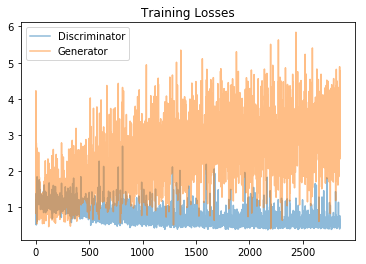

In [28]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [29]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [30]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

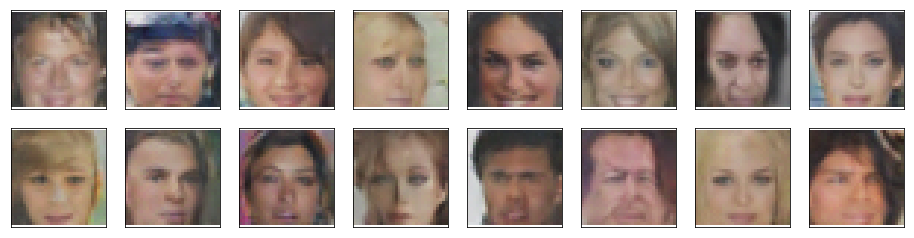

In [31]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 

The model in its current state did not generate good quality images. There are some images that are beginning to look like faces. Some factors could have attributed to this performance are the following:

 - Real Image Quality: When resizing the images, originally I had performed a crop to center which left some of the resolution in the images; however, I realized after I had already trained the network that I was only training essentially the eyes and nose of the face. I subsequently changed the transform to resize. However, when residing the image, the new image looked more pixelated and had less definition. The input image size and transforms on the image have an impact on the results
 - Model Size: The model size is based on the same features and layers as the classroom project on generating numbers. More layers could help learn more features as suggested above. 
 - Model hyperparameters: The hyperparameters were based on the paper referenced in the project ([original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf)). I also adding smoothing for the discriminator losses.
 - Number of Epochs: Originally I tried a higher number of epochs (around 50) but found that the high number of epochs did not necessarily equate to better resuits with the given parameters. I ended up chousing 10 in order to speed up the training time. However, I think if I were to modify some of the hyperparameters and increase the number of epochs, the generate loss and discriminator loss may be able to reach a steady state. Looking at the chart above comparing losses, the generator started out with a high loss and dropped quickly down to discriminator loss; however, the generator loss was not very stable. 
 - The dataset itself is biased as suggested above. Furthermore, it was interesting that the model could not generate the chin. Some features of the face are cut off in the original image (such as the chin). 
 
 
**Resubmission Changes**
 
 - Updated the number of epochs from 10 to 50. 
 - Add more fully connected layers and dropout between the fully connected layers in the discriminator
 - Updated the beta1 term in the optimizers to 0.2 from 0.5
 - Changed the number of batches from 128 to 32
 - I attempted to apply spectral norm to the discriminator and generator functions; however, when I tried to call it from torch.nn.utils.spectral_norm; however, I would get the error message that spectral_norm didn't exist. 
 
 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.